# DENOISING AUTOENCODER FOR MIDI

### **1. Load Libraries**

The imported modules include:

* `torchvision`: contains many popular computer vision datasets, deep neural network architectures, and image processing modules. We will use this to download the CIFAR10 dataset.
* `torch.nn`: contains the deep learning neural network layers such as `Linear()`, and `Conv2d()`.
* `transforms`: will help in defining the image transforms and normalizations.
* `optim`: contains the deep learning optimizer classes such as `MSELoss()` and many others as well.
* `functional`: we will use this for activation functions such as ReLU.
* `DataLoader`: eases the task of making iterable training and testing sets.

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard.writer import SummaryWriter

# torchvision
from torchinfo import summary
from torchvision.utils import save_image

# other
import os
import time
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

#### Dark theme

In [2]:
plt.style.use("dark_background")

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

### **2. Define Constants**

In [4]:
# constants
NUM_EPOCHS = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.00
NUM_PERMUTATIONS = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### **3. Helper Functions**

In [5]:
def compare_plot(a1, a2, t1="noisy", t2="denoised", set_axis="off", video=False):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title(t1)
    plt.imshow(
        np.squeeze(a1),
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    plt.axis(set_axis)
    plt.subplot(2, 1, 2)
    plt.title(t2)
    plt.imshow(
        np.squeeze(a2),
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    plt.axis(set_axis)

    if video:
        dirname = f"video"
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        plt.savefig(
            f"{dirname}/plot-{int(time.time())}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()
    else:
        plt.show()

### **4. Load Data**

In [6]:
clean_images = np.load("all_loops.npz")

In [7]:
def shift_image_vertically(name, array, num_iterations):
    shifted_images = []

    def find_non_zero_bounds(arr):
        # Find the first and last row index with a non-zero element
        rows_with_non_zero = np.where(arr.any(axis=1))[0]
        if len(rows_with_non_zero) == 0:
            return (0, arr.shape[0] - 1)  # Handle case with no non-zero elements
        return rows_with_non_zero[0], rows_with_non_zero[-1]

    def shift_array(arr, up=0, down=0):
        # Shift array vertically
        if up > 0:
            arr = np.roll(arr, -up, axis=0)
            arr[-up:] = 0
        elif down > 0:
            arr = np.roll(arr, down, axis=0)
            arr[:down] = 0
        return arr

    highest, lowest = find_non_zero_bounds(array)
    maximum_up = highest
    maximum_down = array.shape[0] - lowest - 1

    for _ in range(num_iterations):
        # Shift up and then down, decreasing the shift amount in each iteration
        for i in range(maximum_up, 0, -1):
            new_key = f"{Path(name).stem}_u{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, up=i))))
        for i in range(maximum_down, 0, -1):
            new_key = f"{Path(name).stem}_d{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, down=i))))

    random.shuffle(shifted_images)

    return shifted_images[:num_iterations]

### **5. Prepare the Data**

In [8]:
def format_image(image, remove_time=False):
    if remove_time:
        image = np.delete(image, 0, axis=1)
    image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
    if torch.any(image > 1.0):
        image = image / image.max()
    image = F.pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

    return image

In [9]:
def augment_data(clean_images, num_permutations=NUM_PERMUTATIONS, vshift=True):
    """Augments a set of passed-in images by a factor of 2*num_permutations"""
    shifted_images = []
    noisy_images = []

    for name, image in tqdm(
        list(clean_images.items()), unit="images", dynamic_ncols=True
    ):
        time_factor = image[:, 0]  # save time factor
        image = np.delete(image, 0, axis=1)  # remove it from the image though
        if vshift:
            # vertical shift images
            shifted_images.append(shift_image_vertically(name, image, num_permutations))
        else:
            # reformat clean image array
            shifted_images.append([(name, image)])

        # add noise to images
        for si in shifted_images[-1]:
            new_key, shifted_image = si
            for _ in range(num_permutations):
                # normalize
                noisy_image = shifted_image / np.max(shifted_image)

                # corrupt
                noisy_image = torch.from_numpy(
                    noisy_image
                ) + NOISE_FACTOR * torch.randn(noisy_image.shape)

                # reformat
                noisy_image = format_image(noisy_image)

                noisy_images.append((new_key, noisy_image))

    random.shuffle(noisy_images)

    return shifted_images, noisy_images

#### Data augmentation
**WARNING: This may use a ton of memory**

In [10]:
shifted_images, training_data = augment_data(clean_images, vshift=True)

# output_file = f"augmented_data_{int(time.time())}"
# np.savez_compressed(
#     os.path.join("data", output_file),
#     **{name: arr for name, arr in noisy_images},
# )
print(
    f"used {len(list(clean_images.keys()))} clean images to generate {len(training_data)} noisy images of shape {training_data[0][1].size()}"
)

  0%|          | 0/1404 [00:00<?, ?images/s]

used 1404 clean images to generate 5616 noisy images of shape torch.Size([1, 60, 412])


#### View Results

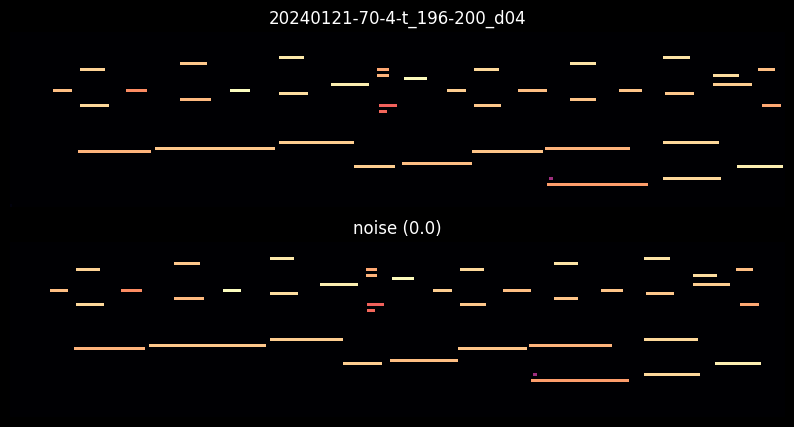

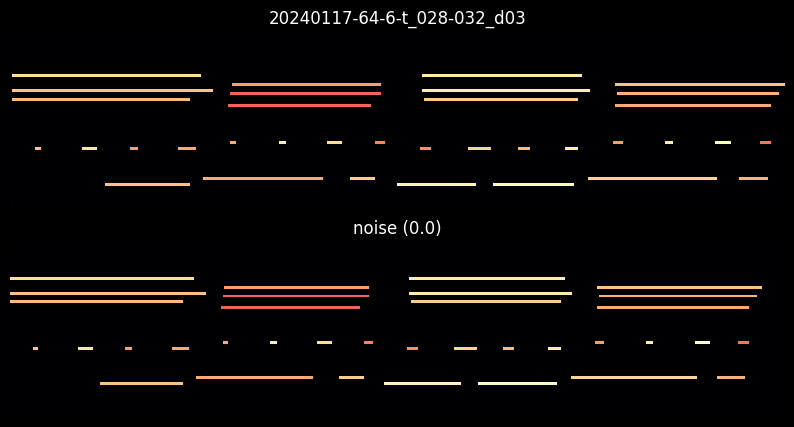

In [11]:
for data in training_data[:2]:
    k, v = data
    compare_plot(
        clean_images[k[: k.rfind("_")] + ".mid"], v, k, f"noise ({NOISE_FACTOR})"
    )

### **6. Define the AutoEncoder**

In [12]:
def initialize_weights(model, a=0.0, b=1.0):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            # Apply uniform initialization to the weights
            nn.init.uniform_(module.weight, a, b)
            # Check if the module has a bias attribute
            if module.bias is not None:
                # Initialize the bias with the same bounds
                nn.init.uniform_(module.bias, a, b)

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = self.pool(F.relu(self.enc3(x)))
        x = self.pool(F.relu(self.enc4(x)))  # latent space representation

        # Decoder
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))

        return x


model = AutoEncoder().to(device)

In [14]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [15]:
summary(model, (1, 58, 400))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

### **7. Optimizer and Loss Function**

In [16]:
# the loss function
loss_fn = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### **8. Train**


#### Function

In [30]:
def train(
    net, training_data, epochs=NUM_EPOCHS, plot=False, save=False, video=False, tb=False
):
    # the loss function
    loss_fn = nn.MSELoss()
    # the optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_loss = []
    noisy_arrays = []  # change to dict
    denoised_arrays = []  # change to dict
    if tb:
        writer = SummaryWriter(f"runs/{int(time.time())}")
    for epoch in trange(epochs, desc="Total "):
        running_loss = 0.0
        with tqdm(training_data, unit="images", dynamic_ncols=False) as tepoch:
            for i, (name, image) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch + 1}")

                if image.min() < 0 or image.max() > 1.0:
                    print(f"WARNING: {name} has values that are out of bounds")

                # train
                image = image.to(device)  # (1, 60, 412)
                outputs = net(image)  # (1, 60, 412)
                loss = loss_fn(outputs, image)
                optimizer.zero_grad()
                loss.backward()  # backpropagation
                optimizer.step()  # update the parameters

                if plot or video:
                    compare_plot(
                        image.cpu().data,
                        outputs.cpu().data,
                        name,
                        f"output (loss={loss})",
                        video=video,
                    )

                # tensorboard logging
                if tb:
                    global_step = epoch * len(training_data) + i
                    writer.add_scalar("training/loss", loss.item(), global_step)
                    for p_name, param in model.named_parameters():
                        writer.add_histogram(
                            f"weights/{p_name}", param.data, global_step
                        )
                        if param.requires_grad:
                            writer.add_histogram(
                                f"gradients/{p_name}.grad", param.grad, global_step
                            )

                running_loss += loss.item()
                tepoch.set_postfix(loss=f"{loss:.02f}")

            loss = running_loss / len(training_data)
            train_loss.append(loss)

            if save:
                noisy_arrays.append((name, image.cpu().data))
                denoised_arrays.append((name, outputs.cpu().data))

    # save images as arrays for later viewing
    noisy_file = f"noisy-{int(time.time())}"
    denoised_file = f"denoised-{int(time.time())}"
    if save:
        np.savez(
            os.path.join("data", noisy_file),
            **{name: arr for name, arr in noisy_arrays},
        )
        np.savez(
            os.path.join("data", denoised_file),
            **{name: arr for name, arr in denoised_arrays},
        )

    if tb:
        writer.close()

    return train_loss, (noisy_file, denoised_file)

#### Run

In [19]:
initialize_weights(model, 0.01, 0.1)
train_loss, output_filenames = train(model, training_data, epochs=1)

Total :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5616 [00:00<?, ?images/s]

  0%|          | 0/5616 [00:00<?, ?images/s]

KeyboardInterrupt: 

#### Plot Loss

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### Test Reconstruction

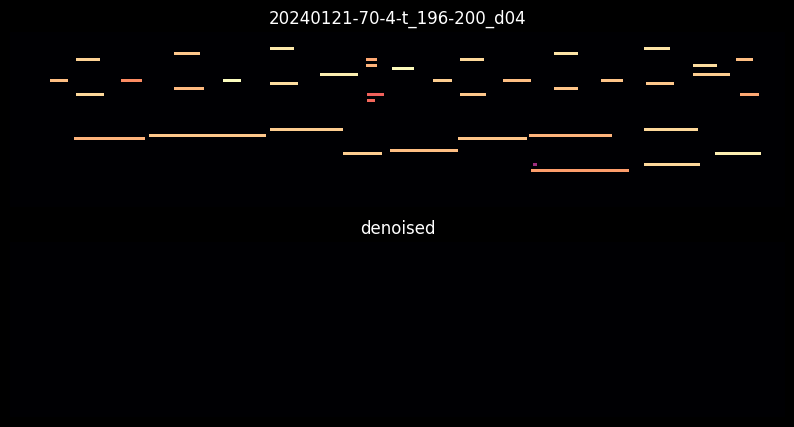

In [20]:
img_noisy = training_data[0][1] + NOISE_FACTOR * torch.randn(training_data[0][1].shape)
img_noisy = img_noisy.to(device)
outputs = model(img_noisy)

compare_plot(img_noisy.cpu().data, outputs.cpu().data, training_data[0][0])

### Overfit Test

In [31]:
si_tensor = [
    (k, torch.from_numpy(np.expand_dims(format_image(v, True), 0)).to(torch.float32))
    for k, v in list(clean_images.items())
]
random.shuffle(si_tensor)
overfit_set = [si_tensor[0]] * 100

model = AutoEncoder().to(device)
initialize_weights(model, 0.01, 0.1)
train(model, overfit_set, epochs=1, tb=True)

Total :   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?images/s]

([0.9835118651390076], ('noisy-1708715069', 'denoised-1708715069'))

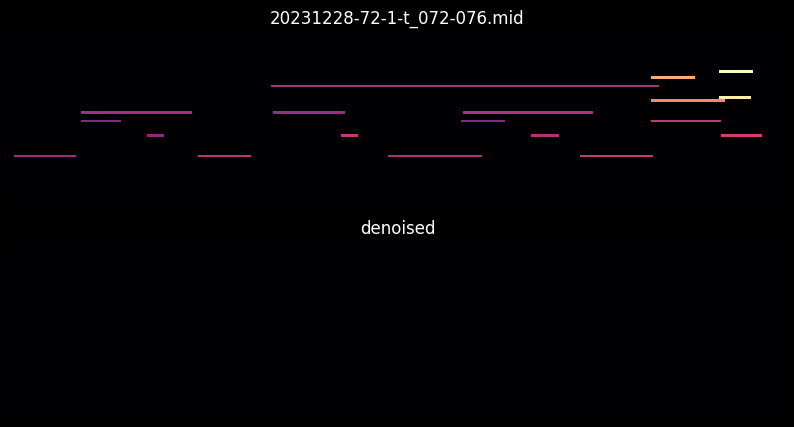

In [32]:
img_noisy = overfit_set[0][1] + NOISE_FACTOR * torch.randn(overfit_set[0][1].shape)
img_noisy = img_noisy.to(device)
outputs = model(img_noisy)

compare_plot(img_noisy.cpu().data, outputs.cpu().data, overfit_set[0][0])

In [23]:
import cv2
import shutil

image_folder = "video"
video_name = "ugh.mp4"
fps = 20

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()  # Sort the images by name

# Determine the width and height from the first image
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(
    video_name, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height)
)

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
shutil.rmtree(image_folder)